In [1]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
from datasets import load_dataset

Twitter = load_dataset("zeroshot/twitter-financial-news-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [3]:
print(Twitter)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})


In [4]:
# Convert the train split to a pandas DataFrame
train_df = Twitter['train'].to_pandas()

# Display the first few rows of the DataFrame
print(train_df.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0


In [5]:
# Convert the train split to a pandas DataFrame
validation_df = Twitter['validation'].to_pandas()

# Display the first few rows of the DataFrame
print(validation_df.head())

                                                text  label
0  $ALLY - Ally Financial pulls outlook https://t...      0
1  $DELL $HPE - Dell, HPE targets trimmed on comp...      0
2  $PRTY - Moody's turns negative on Party City h...      0
3                   $SAN: Deutsche Bank cuts to Hold      0
4                  $SITC: Compass Point cuts to Sell      0


In [6]:
# Print label counts for train split
print("Train split label counts:")
print(train_df['label'].value_counts())

# Print label counts for validation split
print("\nValidation split label counts:")
print(validation_df['label'].value_counts())

Train split label counts:
label
2    6178
1    1923
0    1442
Name: count, dtype: int64

Validation split label counts:
label
2    1566
1     475
0     347
Name: count, dtype: int64


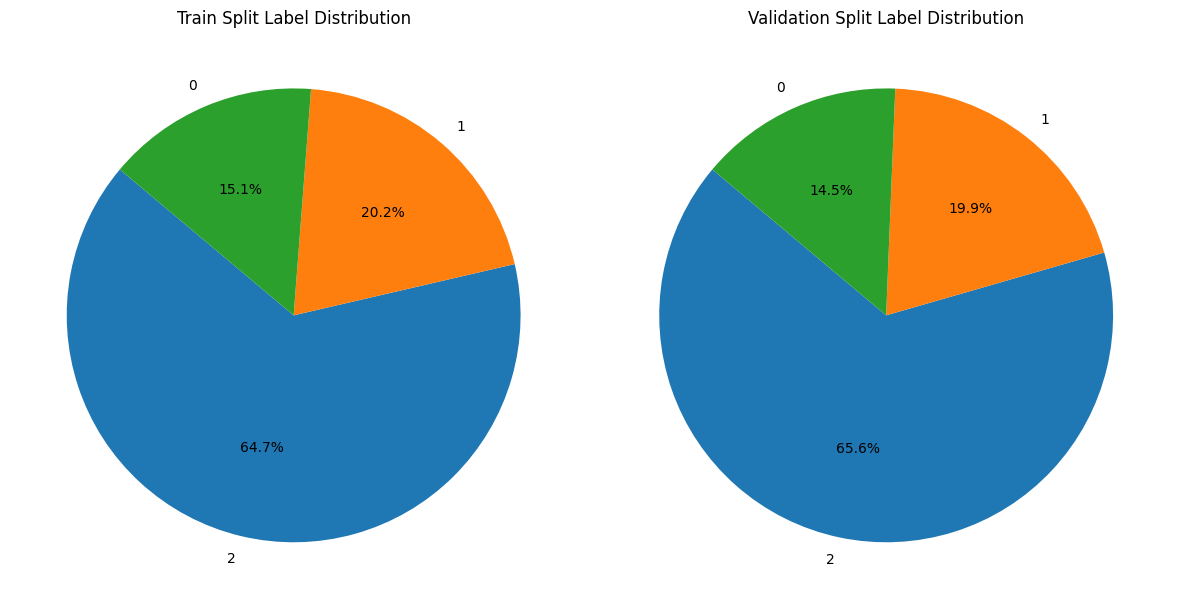

In [7]:
import matplotlib.pyplot as plt

# Label counts for train split
train_label_counts = train_df['label'].value_counts()
train_labels = train_label_counts.index
train_counts = train_label_counts.values

# Label counts for validation split
validation_label_counts = validation_df['label'].value_counts()
validation_labels = validation_label_counts.index
validation_counts = validation_label_counts.values

# Plot pie chart for train split
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(train_counts, labels=train_labels, autopct='%1.1f%%', startangle=140)
plt.title('Train Split Label Distribution')

# Plot pie chart for validation split
plt.subplot(1, 2, 2)
plt.pie(validation_counts, labels=validation_labels, autopct='%1.1f%%', startangle=140)
plt.title('Validation Split Label Distribution')

plt.tight_layout()
plt.show()

In [8]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

In [9]:
# Step 2: Initialize the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Step 3: Tokenize the data
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Apply the preprocessing function
tokenized_datasets = Twitter.map(preprocess_function, batched=True)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [17]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # evaluate after each epoch
    save_strategy="epoch",           # save model checkpoint after each epoch
    learning_rate=5e-5,              # learning rate
    per_device_train_batch_size=16,  # reduced batch size
    per_device_eval_batch_size=16,   # reduced evaluation batch size
    num_train_epochs=10,             # number of epochs
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Step 5: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()}
)

In [ ]:
# Step 6: Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.449100,0.345202,0.875209
